In [53]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [54]:
df_train = pd.read_csv('train.csv')
df_test= pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [55]:
# Для корректной обработки обьеденяем данные

df_train['sample'] = 1 
df_test['sample'] = 0 
df_test['default'] = 0 

df = df_test.append(df_train, sort=False).reset_index(drop=True)

In [56]:
def show_IQR(pd_dataset, column_name, bins_n=10, feature_name=None):
    """ 
       Вспомогательная функция для расчета и визуализации границ выбросов.
       на входе датасет, наименование столбца (признака) и количество столбиков гистограмы
       
       Выводит расчитанные параметры квантилей и гистограммы распределения и boxplot
    """
    data_column = pd_dataset[column_name]
    perc_25 = data_column.quantile(0.25, interpolation="midpoint")
    perc_75 = data_column.quantile(0.75, interpolation="midpoint")
    IQR = perc_75 - perc_25
    print(f'Q1: {perc_25}\nQ3: {perc_75}\nIQR: {IQR}',
          f'\nГраница выбросов: [{perc_25 - 1.5*IQR}, {perc_75 + 1.5*IQR}]')
    print("Пропущено значений:", data_column.isna().sum())
    
    # гистограмма распределения: 
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    sns.distplot(data_column.values, bins=bins_n, color='#50248f')
    plt.title(column_name + ' Distribution - full dataset\n', fontsize=15)
    plt.xlabel(column_name)
    plt.ylabel('Quantity (frequency)')

    # boxplot: 
    plt.subplot(122)
    sns.boxplot(data_column.values, color='#38d1ff')  
    plt.title(column_name + ' Distribution - full dataset\n', fontsize=15)
    plt.xlabel(column_name)
    plt.show()
    
    if feature_name is not None:
        
        # гистограмма распределения: 
        plt.figure(figsize=(15, 4))
        plt.subplot(121)
        sns.distplot(np.log(data_column.values+1), bins=bins_n, color='#a1c9e0')
        plt.title(' логарифм от ' + column_name, fontsize=15)
        plt.xlabel(column_name)
        plt.ylabel('Quantity (frequency)')
        
        # boxplot: распределение признака по целевой переменной
        plt.subplot(122)
        sns.boxplot(x=pd_dataset['default'], y=pd_dataset[column_name])
        plt.title(column_name + ' distribution by default', fontsize=15)
        plt.xlabel('default')
        plt.ylabel(column_name)
        
        plt.show()
    return ''

# Ищем самые значсимые признаки среди числовых
def important_numcols(cols, data):
    imp_num = pd.Series(f_classif(data.query('sample == 1')[cols], data.query('sample == 1')['default'])[0], index = cols)
    imp_num.sort_values(inplace = True)
    imp_num.plot(kind = 'barh', figsize=(15,10))
    return ''

#Функция для заполнения выбросов ближайшим квантилем
def filling_quantile(data, col, change_quant): #quant=0.25 или 0.75
    IQR = data[col].quantile(q=0.75) - data[col].quantile(0.25)
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    high_border = perc75 + 1.5*IQR
    low_border = perc25 - 1.5*IQR
    if change_quant == 0.75:
        data[col] = data[col].apply(lambda x: perc75 if x>perc75 else x)
    elif change_quant == 0.25:
        data[col] = data[col].apply(lambda x: perc25 if x<perc25 else x)
    else:
        print('Значение квантиля должно быть 0.25 или 0.75 :)')
    return data

#Функция для анализа квантилей и выбросов
def func_quantile(data, col):   
    
    IQR = data[col].quantile(q=0.75) - data[col].quantile(0.25)
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    
    # Подсчитаем количество выбросов
    print("Количество выбросов в столбце",col,":",data[data[col]<perc25 - 1.5*IQR][col].count() + data[data[col]>perc75 + 1.5*IQR][col].count())
    data[col].loc[data[col].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 20, label = 'IQR')
    plt.legend()  

# Функция анализа категориальных переменных
def category_info(data, col):
    plt.figure(figsize=(15, 4))
    plt.subplot(121)
    sns.distplot(data[col].values, bins=7, color='#a1c9e0')
    plt.title(' распределение ' + col, fontsize=15)
    plt.xlabel(col)
    plt.ylabel('Quantity (frequency)')
            
    # boxplot: распределение признака по целевой переменной
    plt.subplot(122)
    sns.boxplot(x=data.query('sample == 1')['default'], y=data.query('sample == 1')[col])
    plt.title(col + ': distribution by default', fontsize=15)
    plt.xlabel('default')
    plt.ylabel(col)
    plt.show()

# Вспомогательная функция определения значимых признаков

def important_feature(data, col, key):
    cols = data.loc[:, col].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data.loc[data.loc[:, col] == comb[0], key],
                     data.loc[data.loc[:, column] == comb[1], key]).pvalue \
                <= 0.05/len(combinations_all):
            print('обнаружена статистическая значимость измерения: ', col)
            break

In [57]:
# Смотрим в каком виде данные

df_agg = df.agg({'nunique', lambda s: s.unique()[:10]})\
    .append(pd.Series(df.isnull().sum(), name='null'))\
    .append(pd.Series(df.dtypes, name='dtype'))\
    .transpose()

df_agg

,<lambda>,nunique,null,dtype
client_id,"[74835, 17527, 75683, 26883, 28862, 99881, 266...",110148,0,int64
app_date,"[22MAR2014, 24JAN2014, 23MAR2014, 03FEB2014, 0...",120,0,object
education,"[GRD, SCH, UGR, PGR, nan, ACD]",5,478,object
sex,"[M, F]",2,0,object
age,"[29, 39, 50, 56, 38, 55, 30, 41, 34, 28]",52,0,int64
car,"[Y, N]",2,0,object
car_type,"[Y, N]",2,0,object
decline_app_cnt,"[0, 5, 3, 1, 2, 6, 4, 8, 10, 7]",24,0,int64
good_work,"[0, 1]",2,0,int64
score_bki,"[-2.27188367, -1.50499915, -1.69133904, -2.374...",102618,0,float64


0    100776
1      9372
Name: default, dtype: int64

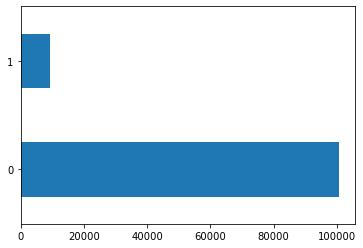

In [58]:
#Соотношение дефолта

df['default'].value_counts().plot.barh()
df['default'].value_counts()

In [59]:
#Бинарные переменные
bin_cols=['sex','car','car_type','good_work','foreign_passport']

#Категориальные переменные
cat_cols=['education','home_address','work_address','app_date','sna'] 

#Числовые переменные
num_cols=['age','decline_app_cnt','income','bki_request_cnt','score_bki','region_rating','first_time']

Q1: 30.0
Q3: 48.0
IQR: 18.0 
Граница выбросов: [3.0, 75.0]
Пропущено значений: 0


C:\Users\nnmal\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\nnmal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


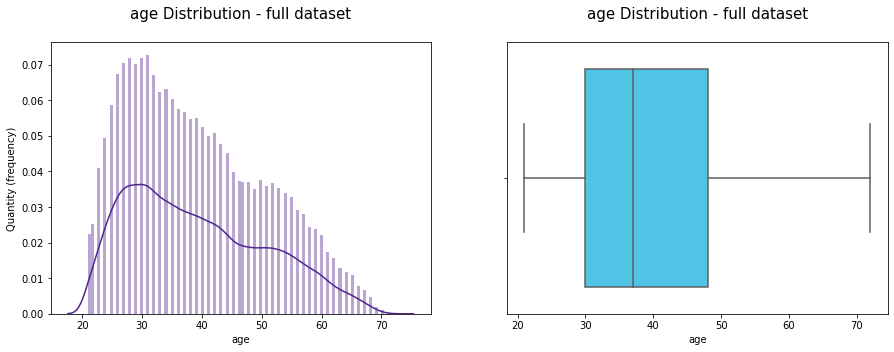

C:\Users\nnmal\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


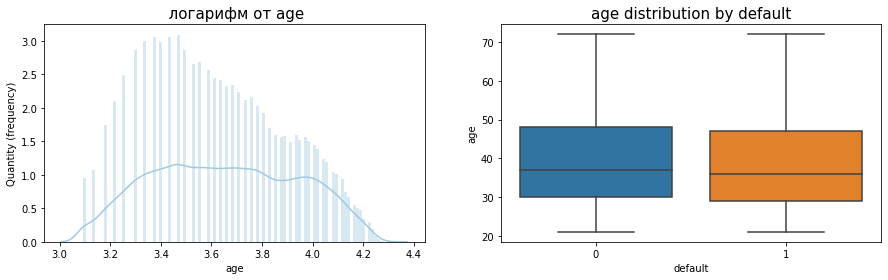

Q1: 0.0
Q3: 0.0
IQR: 0.0 
Граница выбросов: [0.0, 0.0]
Пропущено значений: 0


C:\Users\nnmal\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\nnmal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


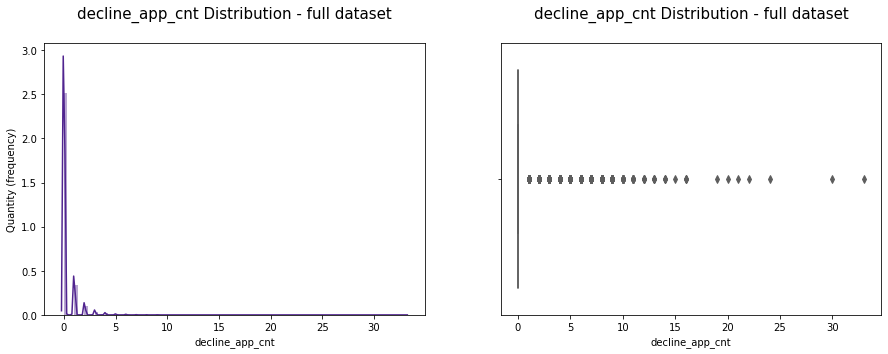

C:\Users\nnmal\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


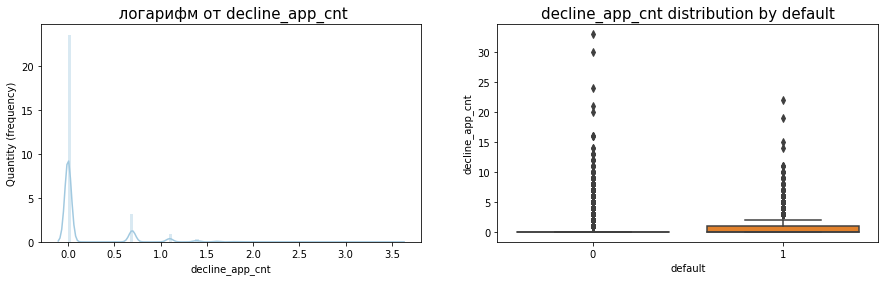

Q1: 20000.0
Q3: 48000.0
IQR: 28000.0 
Граница выбросов: [-22000.0, 90000.0]
Пропущено значений: 0


C:\Users\nnmal\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\nnmal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


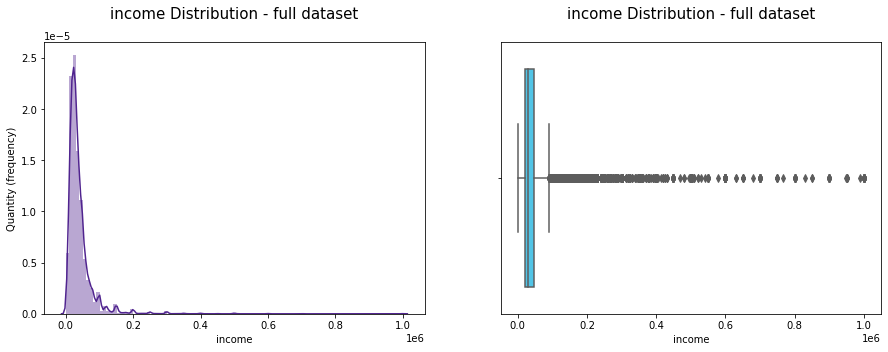

C:\Users\nnmal\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


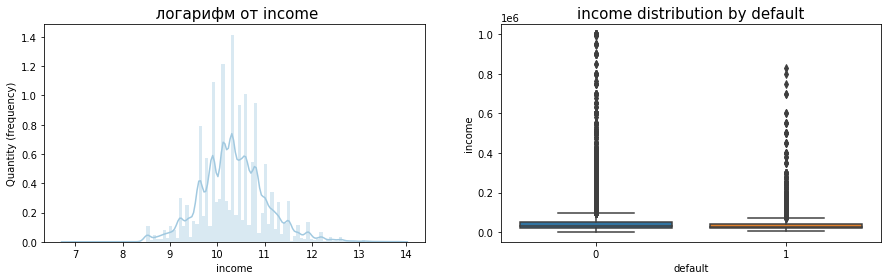

Q1: 0.0
Q3: 3.0
IQR: 3.0 
Граница выбросов: [-4.5, 7.5]
Пропущено значений: 0


C:\Users\nnmal\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\nnmal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


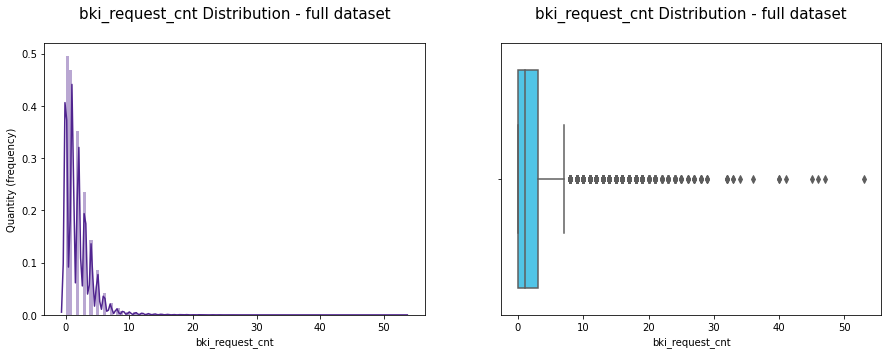

C:\Users\nnmal\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


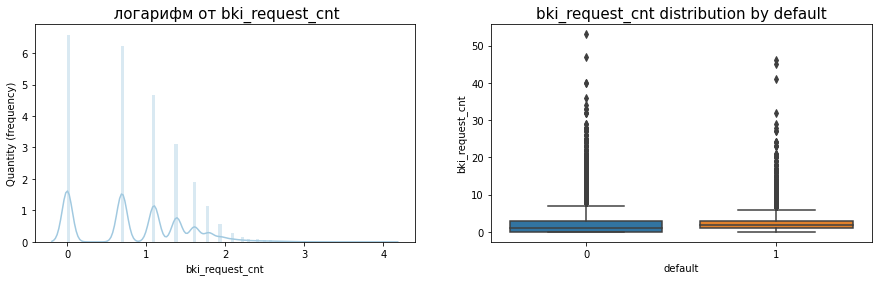

Q1: -2.26044074
Q3: -1.5678840649999999
IQR: 0.6925566750000001 
Граница выбросов: [-3.2992757525, -0.5290490524999998]
Пропущено значений: 0


C:\Users\nnmal\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\nnmal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


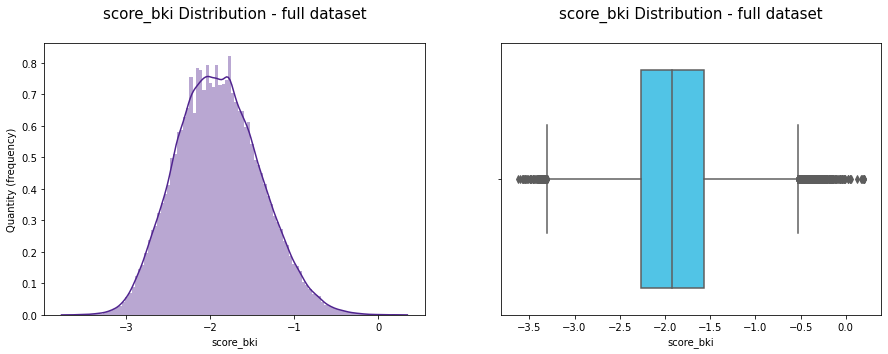

<ipython-input-56-7c139d3458a5>:36: RuntimeWarning: invalid value encountered in log
  sns.distplot(np.log(data_column.values+1), bins=bins_n, color='#a1c9e0')
C:\Users\nnmal\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


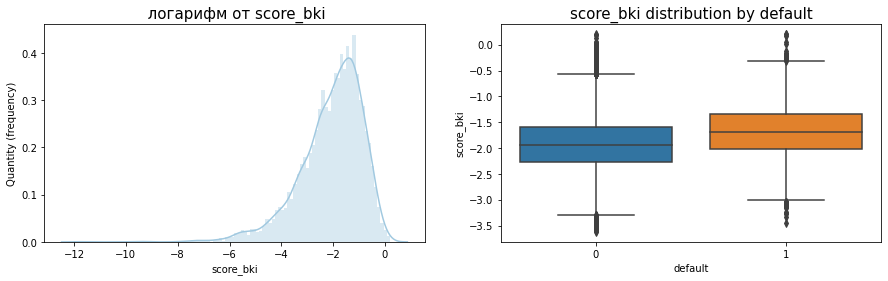

Q1: 50.0
Q3: 60.0
IQR: 10.0 
Граница выбросов: [35.0, 75.0]
Пропущено значений: 0


C:\Users\nnmal\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\nnmal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


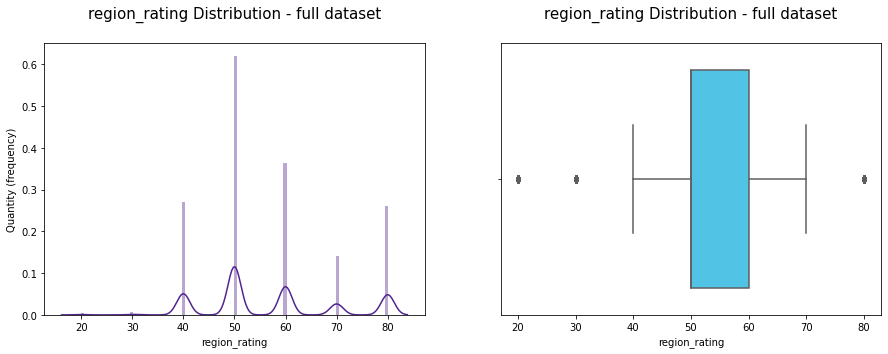

C:\Users\nnmal\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


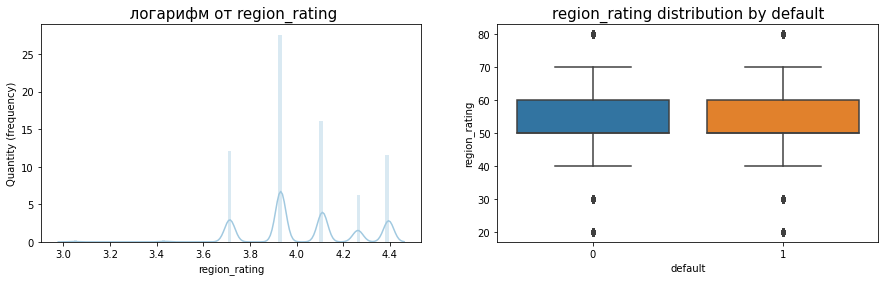

Q1: 2.0
Q3: 4.0
IQR: 2.0 
Граница выбросов: [-1.0, 7.0]
Пропущено значений: 0


C:\Users\nnmal\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\nnmal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


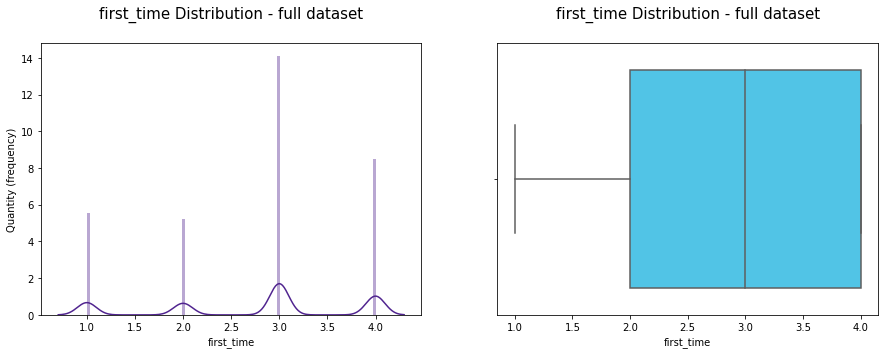

C:\Users\nnmal\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


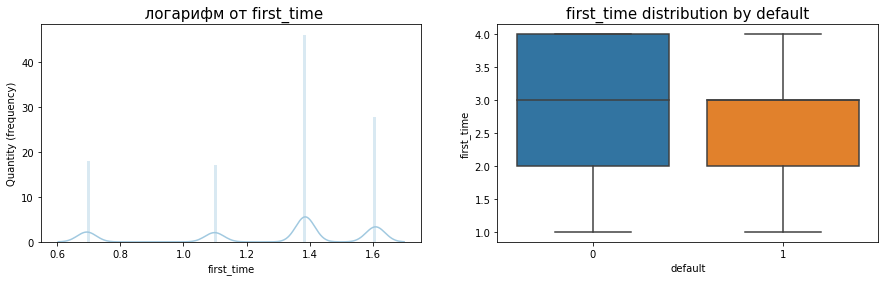

In [60]:
#Рассмотрим распределение числовых данных

for i in num_cols:
    show_IQR(df, i, 100, 'yes')

In [61]:
#Заменяем выбросы в признаке bki_request_cnt на нижний квантиль

df = filling_quantile(df, 'bki_request_cnt', 0.75)

In [62]:
# Попробуем нормальзовать данные в decline_app_cnt 

scaler = MinMaxScaler()
Ranking_norm = scaler.fit_transform(df.loc[:,['decline_app_cnt']]) 
df.loc[:, ['decline_app_cnt']] = Ranking_norm

''

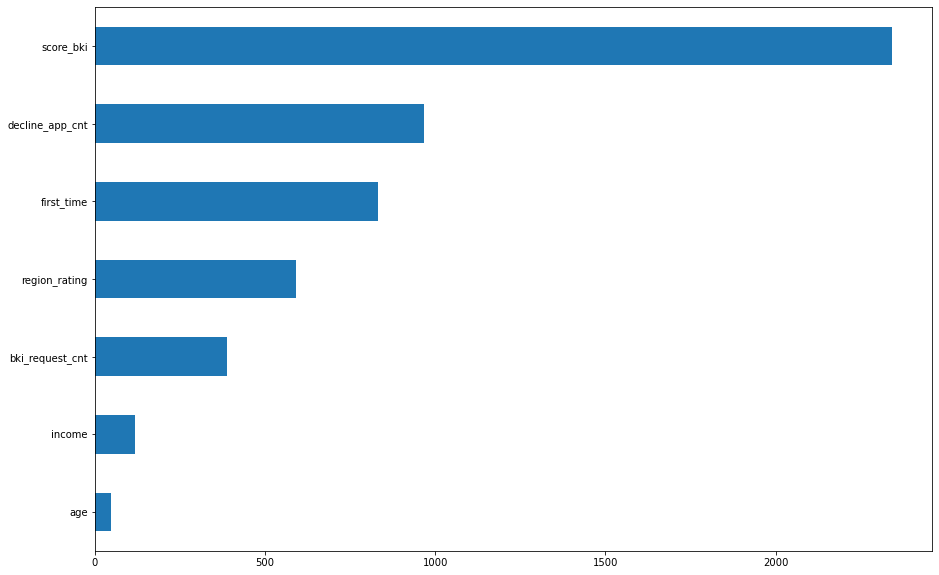

In [63]:
# Рассматриваем важность признаков с помощью функции mutual_info_classif
important_numcols(num_cols, df)

In [64]:
# Посмотрим корреляцию 'income' и 'age'

print(df.loc[:,'default'].astype('float64').corr(df.loc[:,'income']).astype('float64'))
print(df.loc[:,'default'].astype('float64').corr(df.loc[:,'age']).astype('float64'))

-0.03173549858470258
-0.01916936543015273


In [65]:
#Убираем возраст

df = df.drop(columns=['age'])
num_cols = list(set(num_cols) - set(['age']))

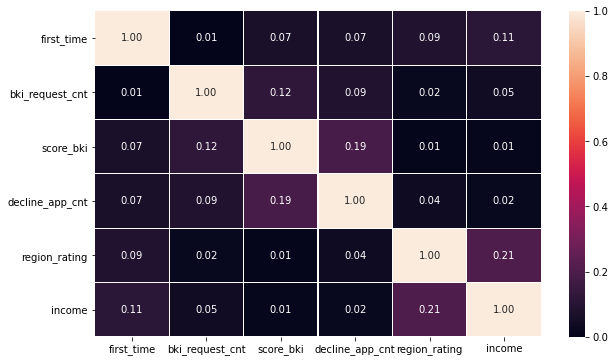

In [66]:
# Построим матрицу корреляций для числовых признаков

f = plt.subplots(figsize=(10, 6))
sns.heatmap(df.query('sample == 1')[num_cols].corr().abs(), vmin=0,
            vmax=1, annot=True, fmt=".2f", linewidths=0.1);

In [67]:
#Преобразуем дату в формат datatime
df['app_date'] = pd.to_datetime(df['app_date'])

# У нас выборка оказалась за первые 4 месяца года, месяцы и оставим, как признак
df['app_date'] = df['app_date'].apply(lambda x: x.month)


Значение моды: 0    SCH
dtype: object


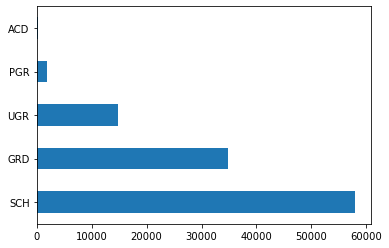

In [68]:
# Смотрим распределения значений и ищем моду для заполнения пропусков в признаке 'education'

df['education'].value_counts().plot.barh()
print('Значение моды:', df.education.mode())

In [69]:
# Заменяем пропуски модой
df['education'] = df['education'].fillna('SCH')

# Выражаем числами
education_grades = ["SCH", "UGR", "GRD", "PGR", "ACD"]
df["education"] = OrdinalEncoder(categories=[education_grades]).fit_transform(df[["education"]]).astype(int)


C:\Users\nnmal\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


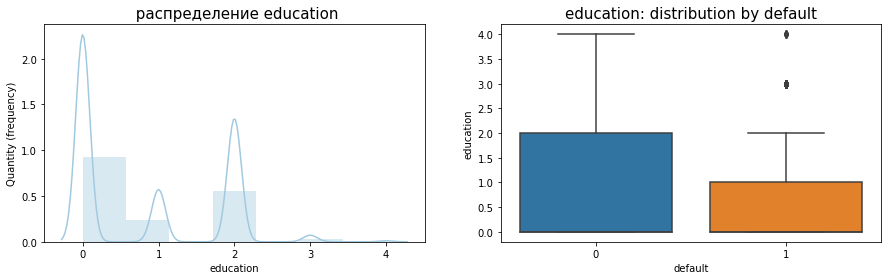

C:\Users\nnmal\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


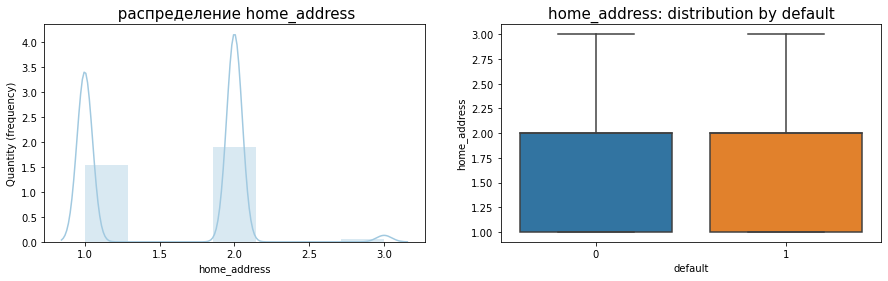

C:\Users\nnmal\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


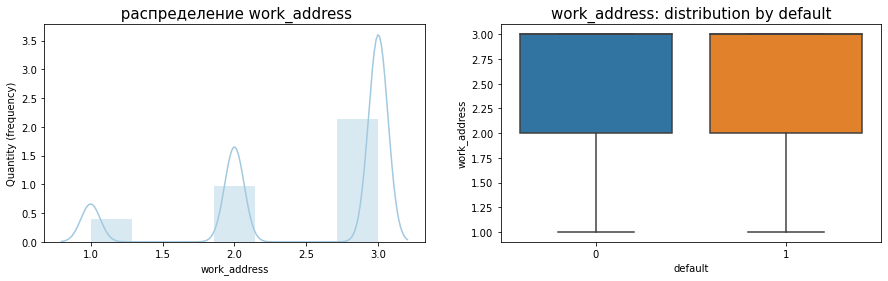

C:\Users\nnmal\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


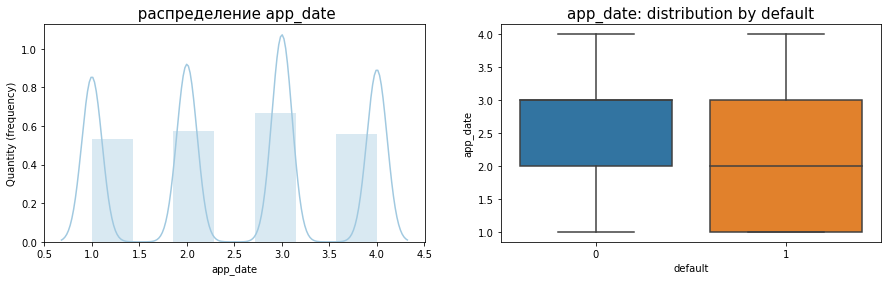

C:\Users\nnmal\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


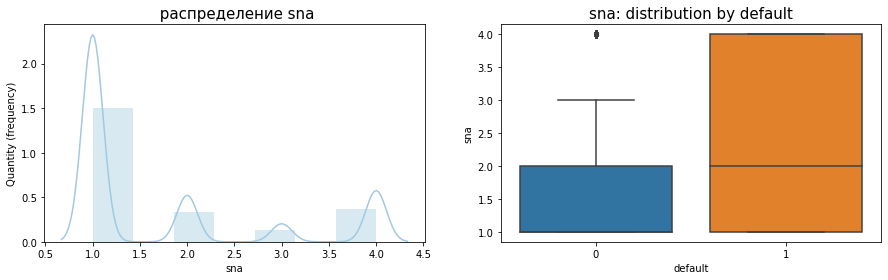

In [70]:
#Рассмотрим распределение категоиральных признаков и их влияние на целевой признак

for i in cat_cols:
    category_info(df, i)

<AxesSubplot:>

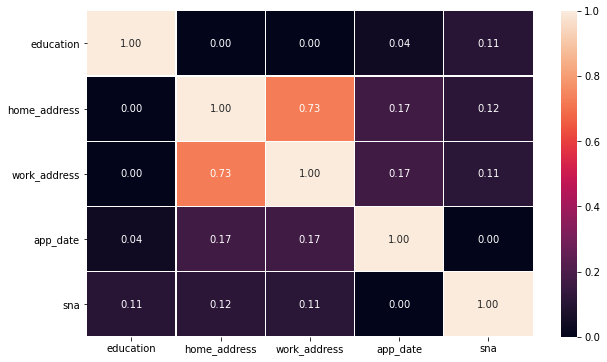

In [71]:
# Построим матрицу корреляций для категориальных признаков

f = plt.subplots(figsize=(10, 6))
sns.heatmap(df.query('sample == 1')[cat_cols].corr().abs(), vmin=0,
            vmax=1, annot=True, fmt=".2f", linewidths=0.1)

<AxesSubplot:>

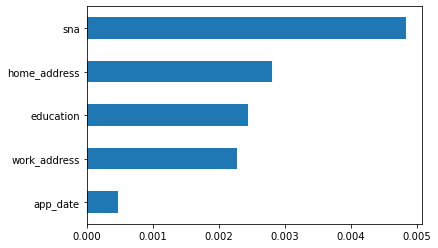

In [72]:
# Рассматриваем значимость категориальных признаков

imp_cat = Series(mutual_info_classif(df[cat_cols], df['default'], discrete_features = True), index = cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [73]:
# Удаляем рабочий адрес

df = df.drop(columns='work_address')
cat_cols = list(set(cat_cols) - set(['work_address']))

In [74]:
# Кодируем бинарные признаки

label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

<AxesSubplot:>

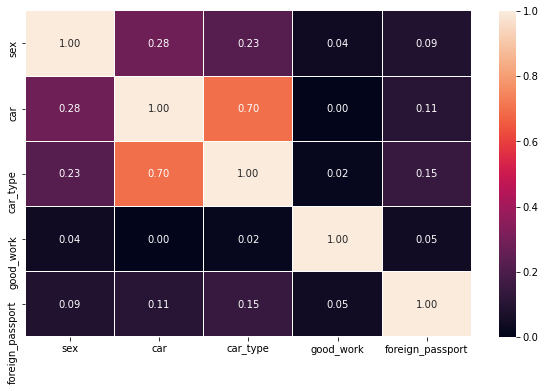

In [75]:
# Построим матрицу корреляций для категориальных признаков

f = plt.subplots(figsize=(10, 6))
sns.heatmap(df.query('sample == 1')[bin_cols].corr().abs(), vmin=0,
            vmax=1, annot=True, fmt=".2f", linewidths=0.1)

<AxesSubplot:>

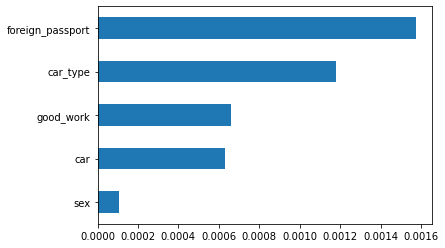

In [76]:
# Рассматриваем значимость бинарных признаков

imp_cat = Series(mutual_info_classif(df[bin_cols], df['default'], discrete_features = True), index = bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [77]:
#Удаляем признак car

df = df.drop(columns=['car'])
bin_cols = list(set(bin_cols) - set(['car']))

In [78]:
#добавим полиноминальные признаки

pf = PolynomialFeatures(2, include_bias=False)
poly_data = pf.fit_transform(df[num_cols])[:, len(num_cols):]
poly_cols = pf.get_feature_names()[len(num_cols):]
poly_df = pd.DataFrame(poly_data, columns=poly_cols)
df = df.join(poly_df, how='left')
num_cols = num_cols + poly_cols

''

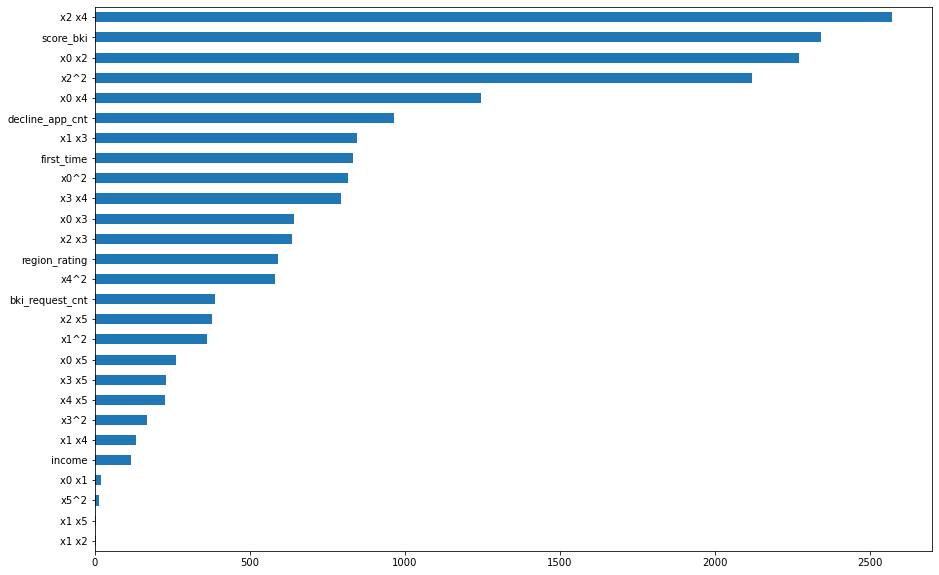

In [79]:
important_numcols(num_cols, df)

In [92]:
imp_num = pd.Series(f_classif(df.query('sample == 1')[num_cols], df.query('sample == 1')['default'])[0], index = num_cols)

# Оставляем 70% самых важных признаков из числовых

final_num_cols = list(imp_num.sort_values(ascending=False).keys()[:int(len(imp_num)*0.7)])
final_num_cols

['x2 x4',
 'score_bki',
 'x0 x2',
 'x2^2',
 'x0 x4',
 'decline_app_cnt',
 'x1 x3',
 'first_time',
 'x0^2',
 'x3 x4',
 'x0 x3',
 'x2 x3',
 'region_rating',
 'x4^2',
 'bki_request_cnt',
 'x2 x5',
 'x1^2',
 'x0 x5']

In [93]:
#Создаем dummy-переменные на основе категориальных признаков

df = pd.get_dummies(df, columns=cat_cols)

In [94]:
bin_cat_cols = list(df.columns)
for x in poly_cols:
    bin_cat_cols.remove(x)
    
# удалим лишние столбцы
bin_cat_cols.remove('client_id')
bin_cat_cols.remove('default')
bin_cat_cols.remove('sample')

<AxesSubplot:>

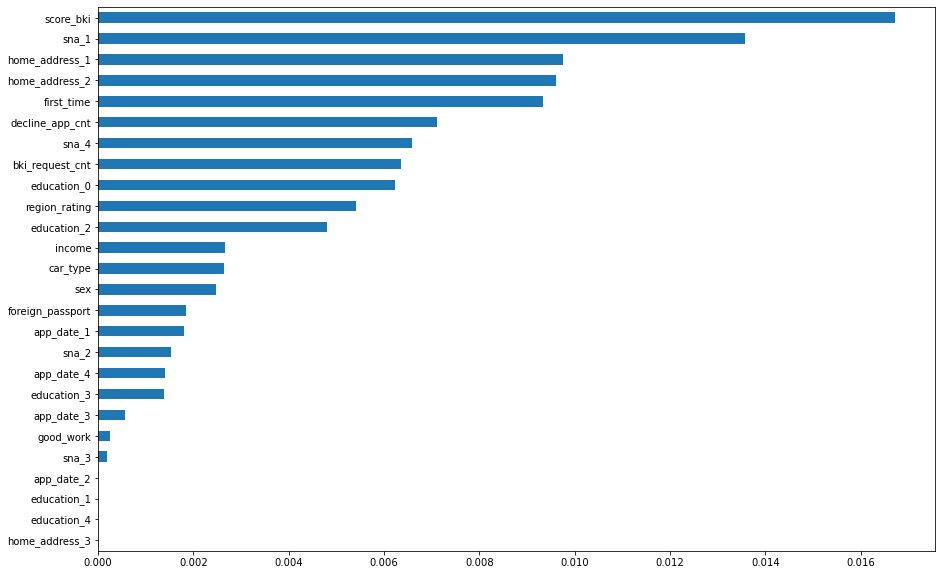

In [95]:
imp_cat = pd.Series(mutual_info_classif(df.query('sample == 1')[bin_cat_cols], df.query('sample == 1')['default']), index = bin_cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh',figsize=(15,10))

In [96]:
#Оставляем 70% наиболее значимых признаков

final_bin_cat_cols = list(imp_cat.sort_values(ascending=False).keys()[:int(len(imp_cat)*0.7)])
final_bin_cat_cols

['score_bki',
 'sna_1',
 'home_address_1',
 'home_address_2',
 'first_time',
 'decline_app_cnt',
 'sna_4',
 'bki_request_cnt',
 'education_0',
 'region_rating',
 'education_2',
 'income',
 'car_type',
 'sex',
 'foreign_passport',
 'app_date_1',
 'sna_2',
 'app_date_4']

<AxesSubplot:>

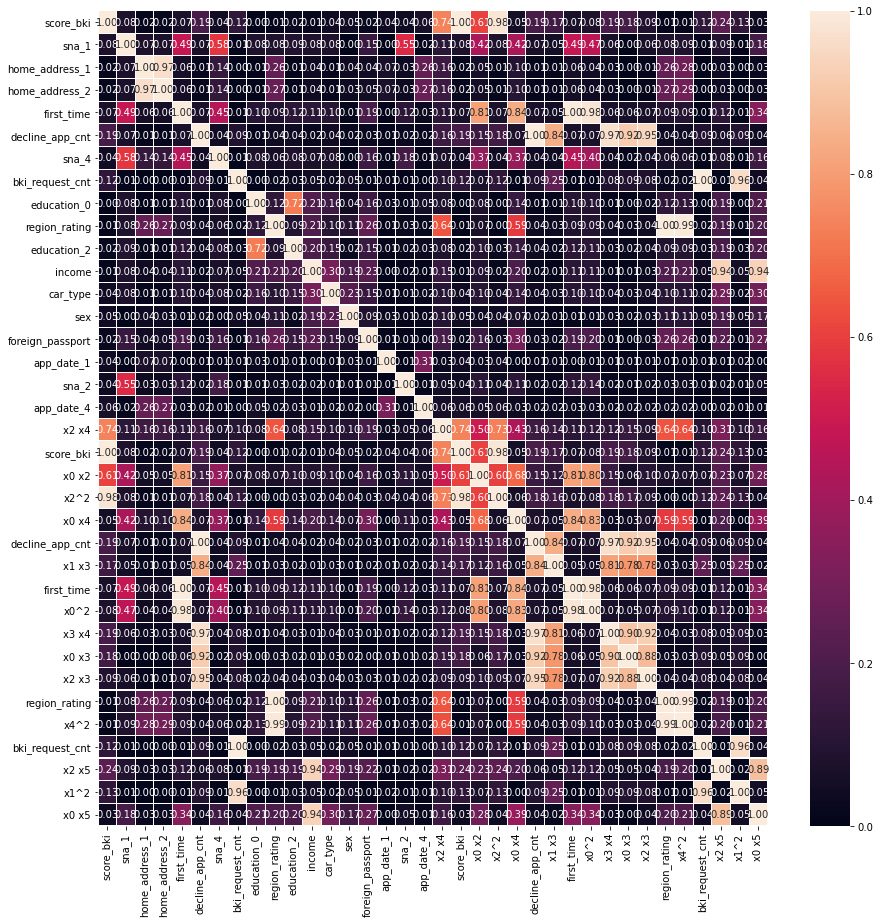

In [97]:
f = plt.subplots(figsize=(15, 15))
sns.heatmap(df.query('sample == 1')[final_bin_cat_cols + final_num_cols].corr().abs(), vmin=0,
            vmax=1, annot=True, fmt=".2f", linewidths=0.1)

In [98]:
# Стандартизация числовых переменных
X_num = StandardScaler().fit_transform(df[final_num_cols].values)
df[final_num_cols] = X_num

In [99]:
# Разделим объединенный датасет на тренировочный и тестовый:

train = df.query('sample == 1')[final_bin_cat_cols + final_num_cols]
test = df.query('sample == 0')[final_bin_cat_cols + final_num_cols]

In [100]:
# Объединяем

X = train.values
Y = df.query('sample == 1').default.values

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [102]:
"""from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression(solver='liblinear', max_iter = 2000)
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])"""

"from sklearn.model_selection import GridSearchCV\n\n# Добавим типы регуляризации\npenalty = ['l1', 'l2']\n\n# Зададим ограничения для параметра регуляризации\nC = np.logspace(0, 4, 10)\n\n# Создадим гиперпараметры\nhyperparameters = dict(C=C, penalty=penalty)\n\nmodel = LogisticRegression(solver='liblinear', max_iter = 2000)\nmodel.fit(X_train, y_train)\n\n# Создаем сетку поиска с использованием 5-кратной перекрестной проверки\nclf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)\n\nbest_model = clf.fit(X_train, y_train)\n\n# View best hyperparameters\nprint('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])\nprint('Лучшее C:', best_model.best_estimator_.get_params()['C'])"

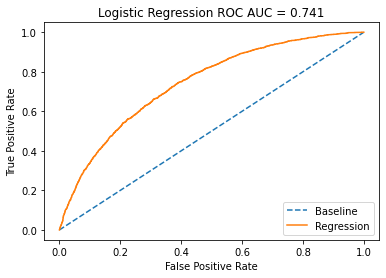

In [103]:
model = LogisticRegression(solver='liblinear', class_weight='balanced', C=1, penalty='l1')
model.fit(X_train, y_train)

probs = model.predict(X_test)
pred_probs = model.predict_proba(X_test)


fpr, tpr, threshold = roc_curve(y_test, pred_probs[:,1])
roc_auc = roc_auc_score(y_test, pred_probs[:,1])

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [104]:
print('accuracy_score:', accuracy_score(y_test, probs))
print('precision_score:', precision_score(y_test, probs))
print('recall_score:', recall_score(y_test, probs))
print('f1_score:', f1_score(y_test, probs))
сf_mtx = confusion_matrix(y_test, probs)
print()
print('confusion matrix:', '\n', сf_mtx)
tn, fp, fn, tp = сf_mtx.ravel()
print()
print('Предсказано невозращение кредита клиентом, вернувшим кредит: {} \n\
 или {}% от всех вернувших \n'.format(fp, round((fp/(fp+tn))*100, 2)))
print('Предсказан возврат кредита клиентом, не вернувшим кредит: {} \n\
или {}% от всех не вернувших\n'.format(fn, 
                                        round((1-recall_score(y_test,probs))*100, 2)))
print()
print('roc_auc_score:', roc_auc_score(y_test, pred_probs[:, 1]))

accuracy_score: 0.6659891598915989
precision_score: 0.2234895740509713
recall_score: 0.6863711001642037
f1_score: 0.3371874159720355

confusion matrix: 
 [[8576 4357]
 [ 573 1254]]

Предсказано невозращение кредита клиентом, вернувшим кредит: 4357 
 или 33.69% от всех вернувших 

Предсказан возврат кредита клиентом, не вернувшим кредит: 573 
или 31.36% от всех не вернувших


roc_auc_score: 0.7410027115031954


In [105]:
sub_test = test.values
submission = df.query('sample == 0')[['client_id', 'default']]
submission['default'] = model.predict_proba(sub_test)[:,1]
display(submission.sample(10))

,client_id,default
15391,109261,0.298506
10323,87918,0.236966
22032,46873,0.415811
10344,79395,0.396466
11551,15510,0.766793
30148,98691,0.208202
27211,109127,0.506897
9566,38360,0.769539
3675,54560,0.487144
24586,29414,0.763041


In [88]:
submission.to_csv('submission.csv', index=False)